# Code to Test HierProb3D's PyTorch3D Rendering
For usage from within Docker container:
1. Start docker container on host with argument `-p 8888:8888`
2. From within docker:
    - Install jupyter notebook: `pip install notebook`
    - Start jupyter notebook: `jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`
3. On the host visit `localhost:8888/tree`

## Autoreload
Automatically reloads files that have changed

In [1]:
%load_ext autoreload
%autoreload 2

## Verbosity Settings
0 - silent; 1 - important only; 2 - everything

In [2]:
verbosity = 1

## Necessary Imports

In [48]:
import os
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if verbosity > 0:
    print(f"Torch {torch.__version__}")
    if torch.cuda.is_available():
        print("CUDA available")
    else:
        print("CUDA unavailable")
    print(f"Device: {device}")
import sys
sys.path.append('/garmentor')
from data.on_the_fly_smpl_train_dataset import OnTheFlySMPLTrainDataset
from configs import paths
from configs.poseMF_shapeGaussian_net_config import get_poseMF_shapeGaussian_cfg_defaults
from renderers.pytorch3d_textured_renderer import TexturedIUVRenderer
import pytorch3d
if verbosity > 0:
    print(f"PyTorch3D {pytorch3d.__version__}")
from models.smpl_official import SMPL
from smplx.lbs import batch_rodrigues
from utils.augmentation.smpl_augmentation import normal_sample_shape
from utils.augmentation.cam_augmentation import augment_cam_t
from utils.augmentation.proxy_rep_augmentation import augment_proxy_representation, random_extreme_crop
from utils.augmentation.rgb_augmentation import augment_rgb
from utils.augmentation.lighting_augmentation import augment_light

Torch 1.11.0
CUDA available
Device: cuda:0
PyTorch3D 0.6.2


## Load Configuration

In [4]:
pose_shape_cfg = get_poseMF_shapeGaussian_cfg_defaults()
if verbosity > 1:
    print(f"Configuration: \n{pose_shape_cfg}")

## Some Default Tensors

In [60]:
x_axis = torch.tensor([1., 0., 0.], device=device, dtype=torch.float32)
delta_betas_std_vector = torch.ones(
    pose_shape_cfg.MODEL.NUM_SMPL_BETAS,
    device=device,
    dtype=torch.float32
) * pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_STD
mean_shape = torch.zeros(
    pose_shape_cfg.MODEL.NUM_SMPL_BETAS,
    device=device,
    dtype=torch.float32
)
mean_cam_t = torch.tensor(
    pose_shape_cfg.TRAIN.SYNTH_DATA.MEAN_CAM_T,
    device=device,
    dtype=torch.float32
)
print(mean_cam_t)
mean_cam_t = mean_cam_t[None, :].expand(pose_shape_cfg.TRAIN.BATCH_SIZE, -1)

tensor([ 0.0000, -0.2000,  2.5000], device='cuda:0')


## Load Train and Validation Datasets and Data Loaders

In [5]:
train_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.TRAIN_POSES_PATH,
    textures_path=paths.TRAIN_TEXTURES_PATH,
    backgrounds_dir_path=paths.TRAIN_BACKGROUNDS_PATH,
    params_from='not_amass',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)

val_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.VAL_POSES_PATH,
    textures_path=paths.VAL_TEXTURES_PATH,
    backgrounds_dir_path=paths.VAL_BACKGROUNDS_PATH,
    params_from='all',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)
if verbosity > 0:
    print("Training:")
    print(f"    Poses found: {len(train_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(train_dataset.grey_textures)} / {len(train_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(train_dataset.backgrounds_paths)}")
    print("Validation:")
    print(f"    Poses found: {len(val_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(val_dataset.grey_textures)} / {len(val_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(val_dataset.backgrounds_paths)}")

Training:
    Poses found: 91106
    Textures found (gray / non-gray): 125 / 792
    Backgrounds found: 99414
Validation:
    Poses found: 33347
    Textures found (gray / non-gray): 32 / 76
    Backgrounds found: 3000


## Train and Validation Data Loaders

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Initialize PyTorch3D Renderer

In [17]:
pytorch3d_renderer = TexturedIUVRenderer(
    device=device,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE,
    projection_type='perspective',
    perspective_focal_length=pose_shape_cfg.TRAIN.SYNTH_DATA.FOCAL_LENGTH,
    render_rgb=True,
    bin_size=32
)

pytorch3d_textured_renderer.TexturedIUVRenderer.__init__::verts_iuv: 
tensor([[[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.

''

## Initialize SMPL model

In [18]:
smpl_model = SMPL(paths.SMPL, num_betas=pose_shape_cfg.MODEL.NUM_SMPL_BETAS).to(device)

## Fetch Training Data

In [64]:
for batch in train_dataloader:
    target_poses = batch['pose'].to(device)
    backgrounds = batch['background'].to(device)
    textures = batch['texture'].to(device)
    print(f"Poses shape: {target_poses.shape}")
    print(f"Backgrounds shape: {backgrounds.shape}")
    print(f"Textures shape: {textures.shape}")
    break
# Randomly sample body shape
target_shapes = normal_sample_shape(
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    mean_shape=mean_shape,
    std_vector=delta_betas_std_vector
)

Poses shape: torch.Size([4, 72])
Backgrounds shape: torch.Size([4, 3, 256, 256])
Textures shape: torch.Size([4, 1200, 800, 3])


In [67]:
target_shapes

tensor([[-0.7280, -0.0132,  1.5487, -0.7238, -0.7549,  0.8452,  0.1076, -1.8777,
          0.0220,  0.7334],
        [ 0.0929,  1.7751,  1.6233,  1.3040, -1.6158,  2.3457,  2.5640,  0.1421,
         -0.6271,  1.3727],
        [ 0.5495,  2.9151, -0.3665,  2.8495, -0.2584, -1.0135,  1.0135, -1.2133,
         -0.5070, -2.7063],
        [ 0.7354, -2.0259,  1.2252, -1.0858, -1.4424,  1.4456,  0.0804, -0.3924,
         -1.2416, -1.9801]], device='cuda:0')

## Convert Axis-Angle Representation to Rotation Matrices

In [42]:
target_poses_rotmats = batch_rodrigues(target_poses.contiguous().view(-1, 3)).view(-1, 24, 3, 3)
# first entry is global orientation
target_glob_rotmats = target_poses_rotmats[:, 0, :, :]
target_poses_rotmats = target_poses_rotmats[:, 1:, :, :]

In [47]:
target_poses_rotmats[0,0]

tensor([[ 0.9771, -0.0935,  0.1913],
        [ 0.1400,  0.9590, -0.2466],
        [-0.1604,  0.2677,  0.9501]], device='cuda:0')

In [63]:
pose_shape_cfg.LOSS.STAGE2

CfgNode({'REDUCTION': 'mean', 'MF_OVERREG': 1.005, 'J2D_LOSS_ON': 'means+samples', 'WEIGHTS': CfgNode({'POSE': 10.0, 'SHAPE': 80.0, 'JOINTS2D': 30000.0, 'GLOB_ROTMATS': 5000.0, 'VERTS3D': 5000.0, 'JOINTS3D': 5000.0})})

In [46]:
target_poses_rotmats.shape

torch.Size([4, 23, 3, 3])

In [9]:
batch['background'].shape

torch.Size([4, 3, 256, 256])

In [10]:
import matplotlib.pyplot as plt

Iteration 0
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,    0,    1],
        [   0,    1,    1],
        [   0,    2,    1],
        ...,
        [1199,  775,    0],
        [1199,  782,    1],
        [1199,  783,    1]])
    Background:


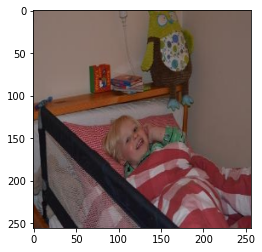

Iteration 1
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,    0,    1],
        [   0,    1,    1],
        [   0,   14,    1],
        ...,
        [1199,  781,    1],
        [1199,  782,    2],
        [1199,  783,    2]])
    Background:


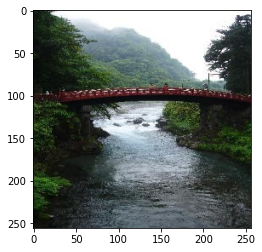

Iteration 2
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,   64,    1],
        [   0,   65,    1],
        [   0,   66,    1],
        ...,
        [1199,  743,    0],
        [1199,  744,    0],
        [1199,  745,    0]])
    Background:


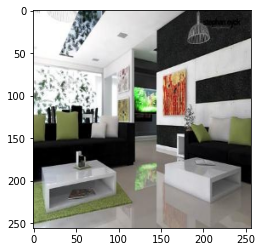

Iteration 3
    Pose: torch.Size([72])
    Texture: torch.Size([1200, 800, 3])
        Non-zero: tensor([[   0,   56,    2],
        [   0,   57,    2],
        [   0,   58,    2],
        ...,
        [1199,  775,    0],
        [1199,  782,    1],
        [1199,  783,    1]])
    Background:


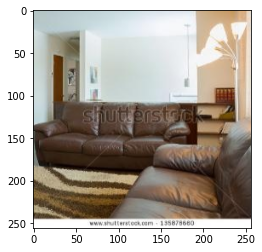

In [11]:
for batch in train_dataloader:
    for i in range(len(batch)+1):
        print(f"Iteration {i}")
        print(f"    Pose: {batch['pose'][i].shape}")
        print(f"    Texture: {batch['texture'][i].shape}")
        print(f"        Non-zero: {torch.nonzero(batch['texture'][i])}")
        print(f"    Background:")
        plt.imshow(batch['background'][i].permute(1,2,0))
        plt.show()

In [12]:
import pytorch3d